## Import Required Libraries

In [2]:
from sklearn import metrics
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Dense,Dropout, Input, Conv2D, Flatten
from keras.models import Sequential
from keras.callbacks import LambdaCallback
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.regularizers import Regularizer
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
from dropconnect_tensorflow import DropConnectDense
import itertools  
import random, shutil
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from keras.optimizers import adam_v2
from keras import optimizers
from keras.models import Sequential

import pandas as pd
import cv2
import pytesseract
from pytesseract import Output
import numpy as np
import seaborn as sns
import pickle
import os
import glob
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import missingno as msno

from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras_tuner.tuners import RandomSearch
import keras_tuner as kt
from IPython.core.display import display, HTML
from sklearn.metrics import roc_curve, auc


In [33]:
DATASET_DIR = 'Datasets\\Image dataset\\'

In [34]:
SAMPLE_DIR = 'Datasets\\d_height_width\\'

In [35]:
TRAINING_DIR = 'Datasets\\Image dataset\\train'
TEST_DIR = 'Datasets\\Image dataset\\test'
VALID_DIR = 'Datasets\\Image dataset\\validation'

In [35]:
width = []
height = []
for file in glob.glob("Datasets/Image dataset/**/*.jpg",
                           recursive = True):
    image = Image.open(file)
    wid = image.width
    h = image.height
    width.append(wid)
    height.append(h)

## Fixing the image height and width

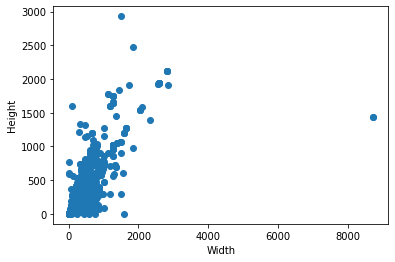

In [47]:
x = width
y = height

plt.scatter(x, y)
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

C:\Users\anshu\anaconda3\envs\tf2.8\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 2000.0)

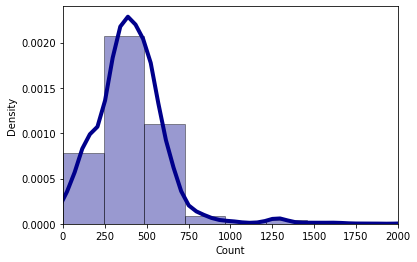

In [53]:
sns.distplot(x, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlabel('Count')
plt.xlim(0, 2000)

C:\Users\anshu\anaconda3\envs\tf2.8\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 2000.0)

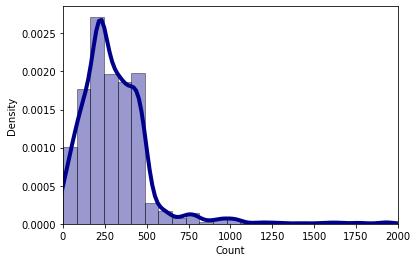

In [58]:
sns.distplot(y, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlabel('Count')
plt.xlim(0, 2000)

In [36]:
im_shape = (400,240) 
seed = 10 
BATCH_SIZE = 32

## Initializing Image Data Generator to read train, test and validation sets

In [37]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)

In [38]:
valid_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)

In [39]:
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = im_shape,
                                                   class_mode = 'binary')

Found 4508 images belonging to 2 classes.


In [40]:
valid_generator = valid_datagen.flow_from_directory(VALID_DIR,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = im_shape,
                                                   class_mode = 'binary')

Found 338 images belonging to 2 classes.


In [41]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = im_shape,
                                                   class_mode = 'binary')

Found 336 images belonging to 2 classes.


In [42]:
nb_train_samples = train_generator.samples
nb_validation_samples = valid_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Classes: ['ham', 'spam']


## Displaying random images from dataset 

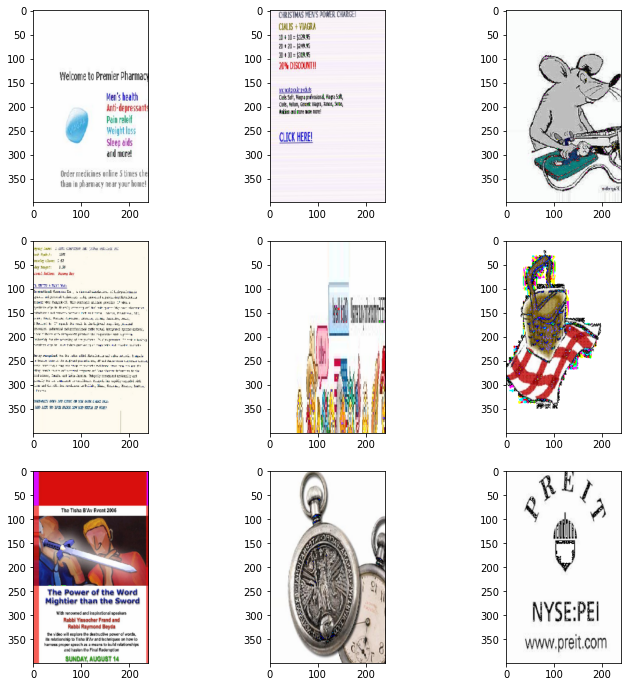

In [14]:
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = (train_generator.next()[0] + 1) * 255
    image = batch[0].astype('uint8')
    plt.imshow(image)

## Defining CNN model

In [16]:
with tf.device("/cpu:0"):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),padding='same',input_shape=(400, 240, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

C:\Users\anshu\anaconda3\envs\tf2.8\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 240, 32)      896       
                                                                 
 activation (Activation)     (None, 400, 240, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 398, 238, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 398, 238, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 199, 119, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 199, 119, 32)      0         
                                                      

## Performing model fitting 

In [18]:
with tf.device("/cpu:0"):
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        steps_per_epoch = train_generator.n // 32,
        epochs = 15
    )

Epoch 1/15
140/140 [==============================] - 1028s 7s/step - loss: 0.9781 - accuracy: 0.6785 - val_loss: 0.5641 - val_accuracy: 0.6893
Epoch 2/15
140/140 [==============================] - 1083s 8s/step - loss: 0.4082 - accuracy: 0.8503 - val_loss: 0.2492 - val_accuracy: 0.9556
Epoch 3/15
140/140 [==============================] - 1093s 8s/step - loss: 0.3352 - accuracy: 0.9062 - val_loss: 0.3460 - val_accuracy: 0.9053
Epoch 4/15
140/140 [==============================] - 1108s 8s/step - loss: 0.2774 - accuracy: 0.9234 - val_loss: 0.0949 - val_accuracy: 0.9734
Epoch 5/15
140/140 [==============================] - 1150s 8s/step - loss: 0.2466 - accuracy: 0.9276 - val_loss: 0.1081 - val_accuracy: 0.9763
Epoch 6/15
140/140 [==============================] - 1205s 9s/step - loss: 0.2397 - accuracy: 0.9305 - val_loss: 0.1531 - val_accuracy: 0.9556
Epoch 7/15
140/140 [==============================] - 1092s 8s/step - loss: 0.1953 - accuracy: 0.9403 - val_loss: 0.1086 - val_accuracy:

## Plotting training V/S validation loss curves

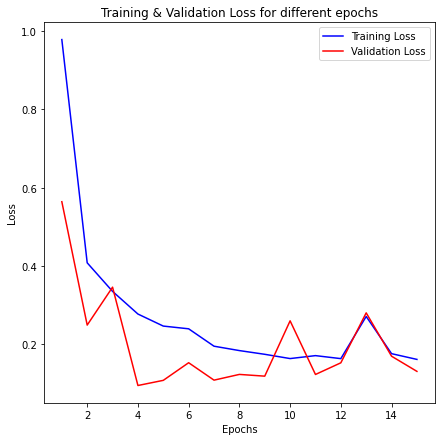

In [28]:
epochs = range(1,len(history.history['loss'])+1)
plt.figure(figsize=(7,7))
plt.plot(epochs, history.history['loss'], 'b', label = 'Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r', label = 'Validation Loss')
plt.title('Training & Validation Loss for different epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Plotting training V/S validation accuracy curves

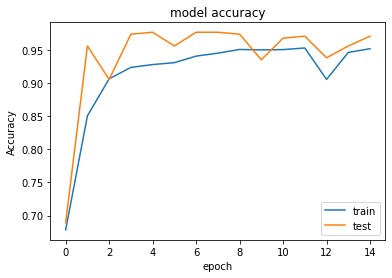

In [29]:
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

## Displaying Validation loss and accuracy

In [43]:
score = new_model.evaluate(valid_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

11/11 [==============================] - 8s 579ms/step - loss: 0.1412 - accuracy: 0.9675
Val loss: 0.14123690128326416
Val accuracy: 0.9674556255340576


## Displaying Validation loss and accuracy

In [32]:
score = new_model.evaluate(test_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

11/11 [==============================] - 2s 163ms/step - loss: 0.0995 - accuracy: 0.9583
Val loss: 0.09953798353672028
Val accuracy: 0.9583333134651184


## Saving the final model

In [44]:
filename = 'models/feature_model_final'
model.save('models/feature_model_final')